In [2]:
from Testing_Stacks import *

In [3]:
Aug_ConvLSTM_model = AugementedConvLSTM(
    projection_height = 129, 
    projection_width = 135,
    timesteps=4
    )
model = Aug_ConvLSTM_model.model(
    [32, 16, 16], 
    [9,5,3], 
    [64,32,1], 
    [9,3,5], 
    2
    )

2022-06-07 12:51:16.567504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 12:51:19.470724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9631 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:18:00.0, compute capability: 7.5
2022-06-07 12:51:19.472235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9631 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-06-07 12:51:19.473457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/r

In [4]:
model.load_weights('convlstm_weights.h5')

In [20]:
def get_yy_hat(model_name, model):
    X, Y = load_dataset(model_name, mon = True)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    for xx, yy in itertools.islice(generator, 0, 1, 1):
        print(xx.shape, yy.shape)
    yy_hat = model.predict(generator)
    print(yy_hat.shape)
    np.save(rf"npy_Files/yy_hat_{model_name}_mon.npy", yy_hat)

In [21]:
'''
Mean of GCM Data:  8.114538545086183e-06
Variance of GCM Data:  1.7407807041548293e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
'''
get_yy_hat('MIROC-ESM', model)

Mean of GCM Data:  8.114538545086183e-06
Variance of GCM Data:  1.7407807041548293e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(692, 129, 135, 1)


In [22]:
'''
Mean of GCM Data:  8.335600091009999e-06
Variance of GCM Data:  1.8536494462990372e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
'''
get_yy_hat('HadGEM2-ES', model)

Mean of GCM Data:  8.335600091009999e-06
Variance of GCM Data:  1.8536494462990372e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(692, 129, 135, 1)


In [23]:
'''
Mean of GCM Data:  5.9594309469595396e-06
Variance of GCM Data:  1.4035182918278377e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
'''
get_yy_hat('CanESM2', model)

Mean of GCM Data:  5.9594309469595396e-06
Variance of GCM Data:  1.4035182918278377e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(692, 129, 135, 1)


In [24]:
'''
Mean of GCM Data:  9.00459581816228e-06
Variance of GCM Data:  1.787250305124021e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
'''
get_yy_hat('GFDL-CM3', model)

Mean of GCM Data:  9.00459581816228e-06
Variance of GCM Data:  1.787250305124021e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841
(1, 4, 129, 135, 7) (1, 129, 135, 1)
(692, 129, 135, 1)


In [32]:
from tqdm import tqdm
def get_RMSE(model_name):
    X, Y = load_dataset(model_name, mon = True)
    X, Y, std_observed = set_data(X, Y)
    generator = data_generator(X,Y)
    yy_hat = np.load(rf"npy_Files/yy_hat_{model_name}_mon.npy")
    rmse = np.zeros((129,135))
    rmse_hist = np.zeros((yy_hat.shape[0],129,135))
    cnt = 0
    for xx, yy in tqdm(itertools.islice(generator, 0, None, 1)):
        yy_pred = yy_hat[cnt].reshape(129,135)
        yy = yy.reshape(129,135)
        rmse += np.square(yy - yy_pred)
        cnt += 1
        rmse_hist[cnt-1] = np.sqrt(rmse/cnt)
    rmse = np.sqrt(rmse/cnt)
    np.save(rf"npy_Files/rmse_hist_{model_name}_mon.npy", rmse_hist)
    plot_RMSE(model_name)
    
def plot_RMSE(model_name):
    rmse = np.load(rf"npy_Files/rmse_hist_{model_name}_mon.npy")[-1]
    
    FileName = r"/home/uditbhatia/Documents/Sarth/Downscaling_AugmentedConvLSTM/03_Preprocess_Data/npy_Files/SRTM_US.npy"
    elev = np.load(FileName)
    mask = np.zeros((129,135))
    mask[39:90,12:123] = np.array(elev)
    indices = np.where(mask == 0)
    rmse[indices] = np.nan

    fig,ax = plt.subplots(1,2, figsize = (20,10))
    sns.heatmap(np.flip(rmse, axis = 0), cmap = 'rainbow', ax =ax[0])
    ax[0].axis('off')
    ax[1].boxplot(rmse[~np.isnan(rmse)], vert = False)
    plt.suptitle(f"{model_name} : RMSE Plot", fontsize = 16)

Mean of GCM Data:  8.114538545086183e-06
Variance of GCM Data:  1.7407807041548293e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841


692it [00:01, 673.96it/s]


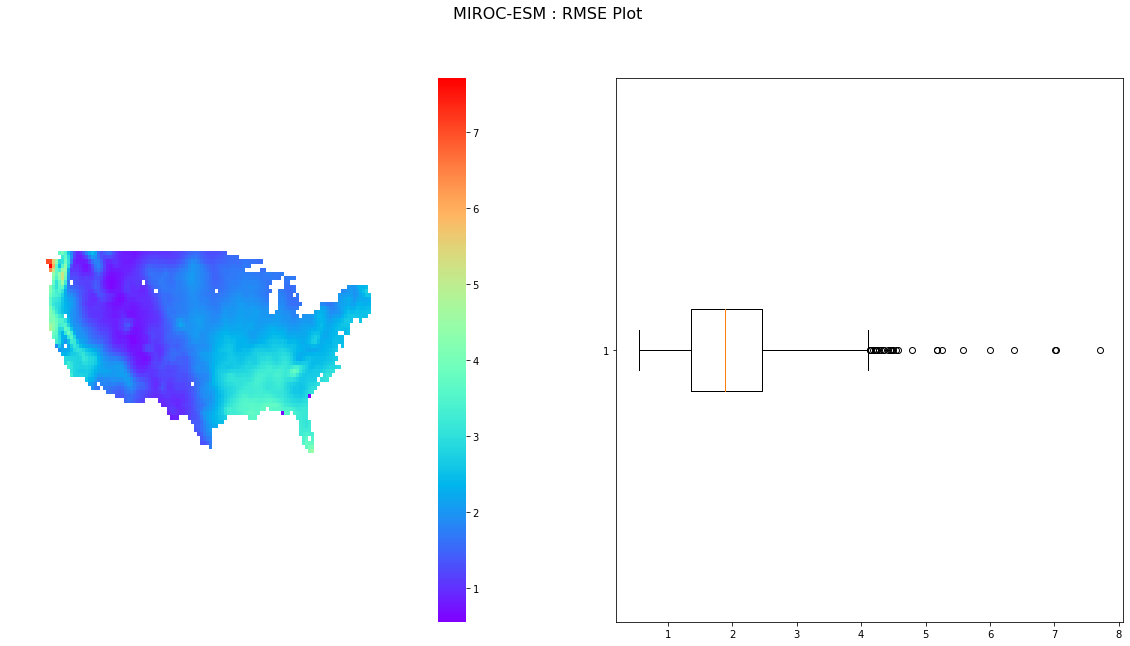

In [33]:
get_RMSE('MIROC-ESM')

Mean of GCM Data:  5.9594309469595396e-06
Variance of GCM Data:  1.4035182918278377e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841


692it [00:00, 761.63it/s]


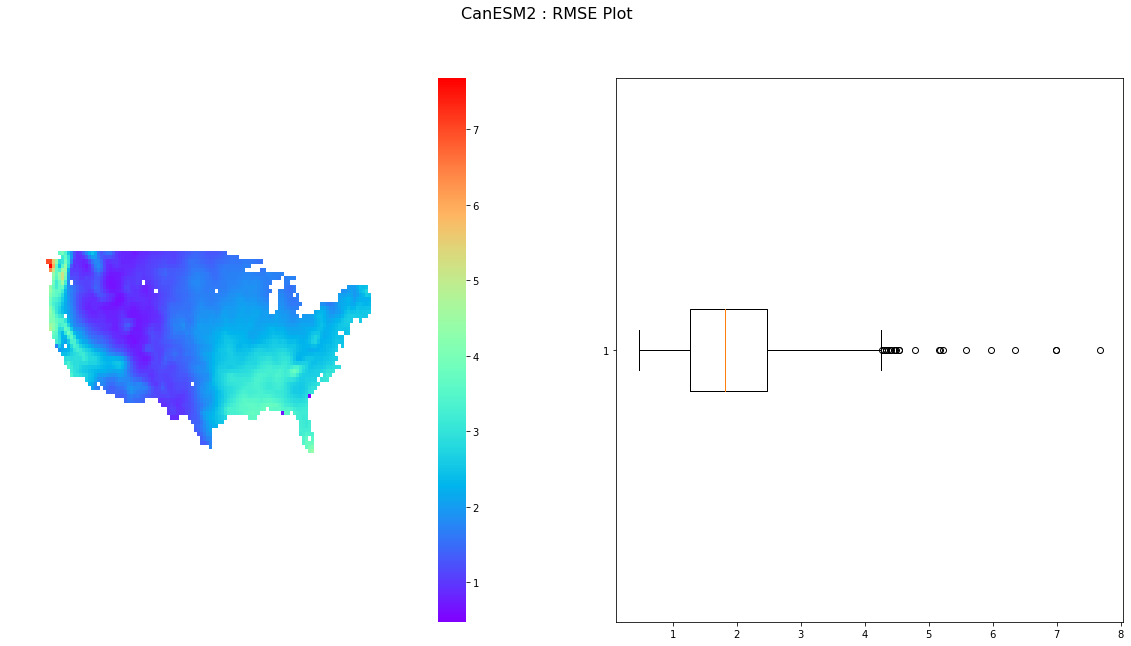

In [34]:
get_RMSE('CanESM2')

Mean of GCM Data:  8.335600091009999e-06
Variance of GCM Data:  1.8536494462990372e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841


692it [00:00, 757.77it/s]


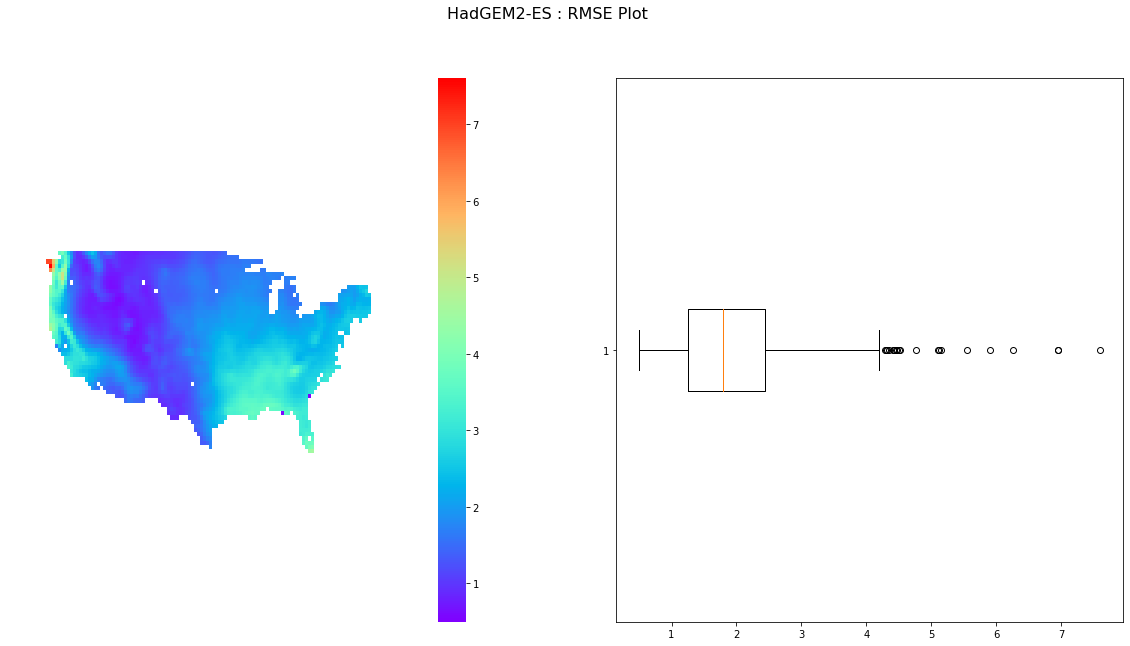

In [35]:
get_RMSE('HadGEM2-ES')

Mean of GCM Data:  9.00459581816228e-06
Variance of GCM Data:  1.787250305124021e-05
Mean of Obseved Data:  14.309589316472854
Variance of Obseved Data:  37.17694297061841


692it [00:00, 703.53it/s]


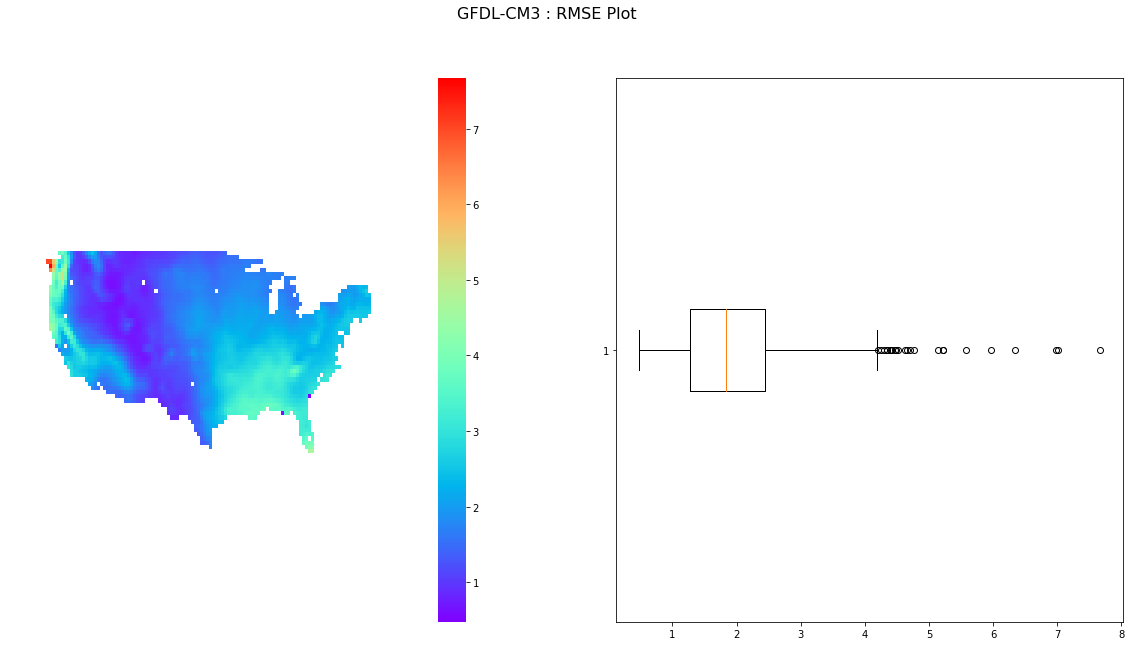

In [36]:
get_RMSE('GFDL-CM3')